# 駅のホームの混雑状況

駅のホームにカメラを設置して顔検出をすることで、ホームの混雑状況やデータを取ることで時間帯別の混雑時を調べることが出来る。

In [19]:
#インストール
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


YOLOを使用する。<br>
画像を読み込み、顔を検出する。

検出された顔の数:34


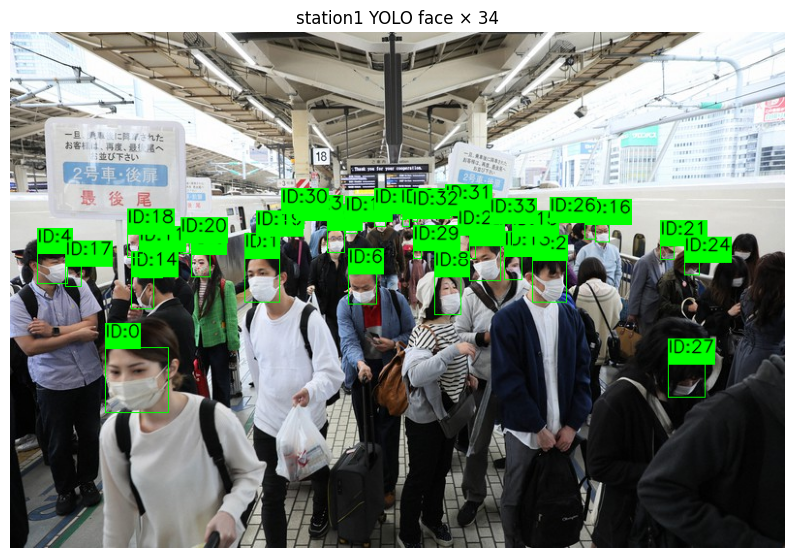

検出された顔の数:11


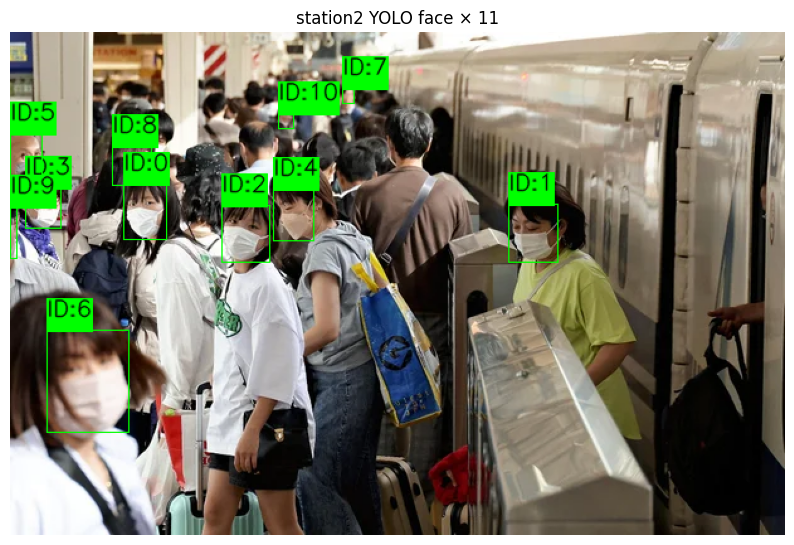

In [20]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. 準備（複数の画像パスをリストに格納）
image_paths = [Path("station1.jpg"), Path("station2.jpg")]
model_path = Path("yolov8m-face.pt")
model = YOLO(model_path)

# --- 描画スタイルの設定 ---
color = (0, 255, 0)
font_scale = 0.6
thickness = 1
pad_ratio = 0.05

# 2. ループで1枚ずつ処理
for img_path in image_paths:
    if not img_path.exists():
        print(f"スキップ: {img_path} が見つかりません。")
        continue

    # YOLO で推論
    result = model.predict(source=str(img_path), conf=0.25, verbose=False, imgsz=1280)[0]
    
    # 画像読み込み
    annotated = cv2.imread(str(img_path))
    h_img, w_img = annotated.shape[:2]

    # 検出結果を1つずつ描画
    for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)
        w, h = x2 - x1, y2 - y1
        
        pad = int(max(w, h) * pad_ratio)
        x1p, y1p = max(0, x1 - pad), max(0, y1 - pad)
        x2p, y2p = min(w_img, x2 + pad), min(h_img, y2 + pad)
        
        cv2.rectangle(annotated, (x1p, y1p), (x2p, y2p), color, thickness)
        
        label = f"ID:{idx}"
        (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        y_label = y1p - 5 if y1p - 5 > h_label else y1p + h_label + 5
        
        cv2.rectangle(annotated, (x1p, y_label - h_label - baseline), (x1p + w_label, y_label + baseline), color, -1)
        cv2.putText(annotated, label, (x1p, y_label - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

    # 3. 保存処理（元のファイル名に _detected を付けて保存）
    output_path = img_path.parent / f"{img_path.stem}_detected{img_path.suffix}"
    cv2.imwrite(str(output_path), annotated)
    print(f"検出された顔の数:{len(result.boxes)}")

    # 4. 表示
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'{img_path.stem} YOLO face × {len(result.boxes)}')
    plt.show()

検出した顔を匿名化するためにぼかしをいれる。

ぼかし画像を保存しました: station1_detected_blurred.jpg


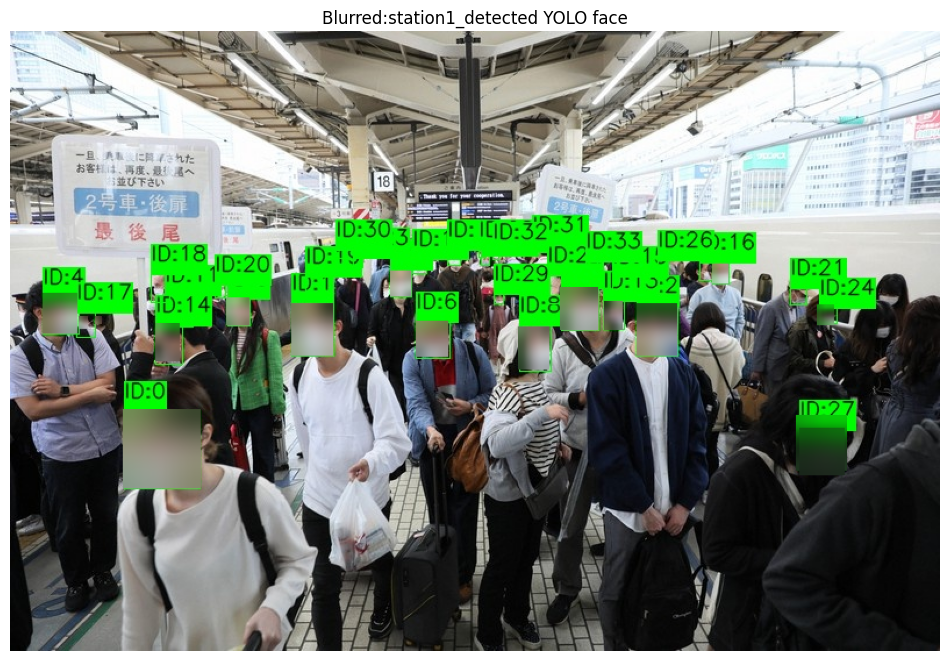

ぼかし画像を保存しました: station2_detected_blurred.jpg


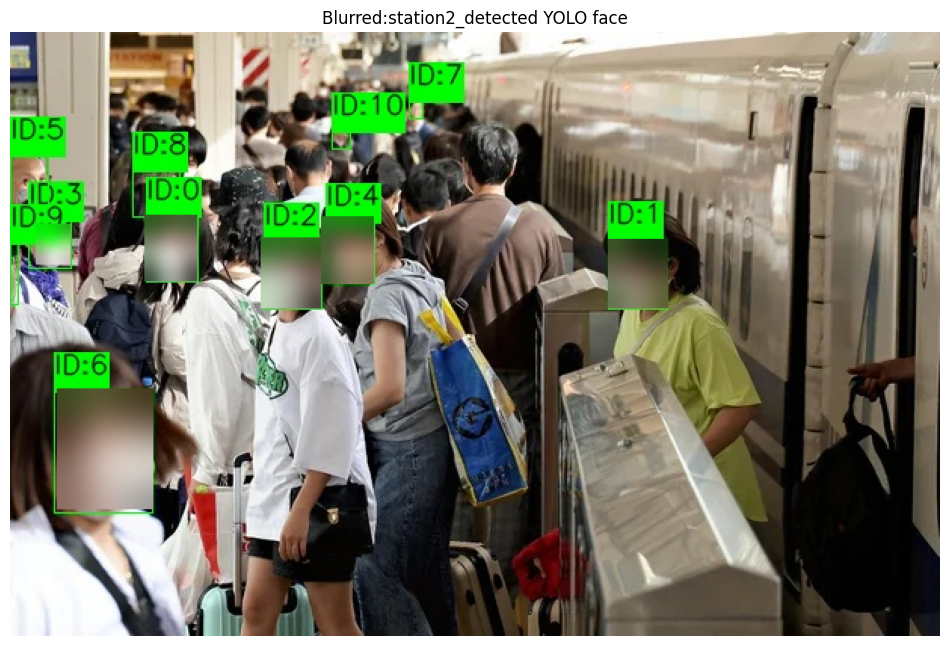

In [21]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO

def blur_faces(image_path, model):
    """
    指定された画像の顔を検出し、ぼかしをかけて保存・表示する関数
    """
    img_path = Path(image_path)
    if not img_path.exists():
        print(f"スキップ: {img_path} が見つかりません。")
        return

    # 画像読み込み
    img = cv2.imread(str(img_path))
    h_img, w_img = img.shape[:2]
    
    # YOLO 推論 (imgsz=1280で高精度)
    result = model.predict(source=str(img_path), conf=0.25, verbose=False, imgsz=1280)[0]
    
    out = img.copy()

    # パラメータ設定
    pad_ratio = 0.05 

    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        w, h = x2 - x1, y2 - y1
        
        # ぼかし範囲の計算
        pad = int(max(w, h) * pad_ratio)
        x1p, y1p = max(0, x1 - pad), max(0, y1 - pad)
        x2p, y2p = min(w_img, x2 + pad), min(h_img, y2 + pad)
        
        face = out[y1p:y2p, x1p:x2p]
        if face.size == 0:
            continue
            
        # ぼかし強度の計算（顔の大きさに合わせる）
        k = max(5, min(face.shape[0], face.shape[1]) // 2)
        if k % 2 == 0: k += 1
            
        # 2回かけて強くぼかす
        face_blur = cv2.GaussianBlur(face, (k, k), 30)
        face_blur = cv2.GaussianBlur(face_blur, (k, k), 30)
        out[y1p:y2p, x1p:x2p] = face_blur

    # 保存
    output_path = img_path.with_name(f"{img_path.stem}_blurred.jpg")
    cv2.imwrite(str(output_path), out)
    print(f'ぼかし画像を保存しました: {output_path}')

    # 表示
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Blurred:{img_path.stem} YOLO face')
    plt.show()

# --- 実行部分 ---

# モデルはループの外で1回だけ読み込む（効率化のため）
model = YOLO('yolov8m-face.pt')

# 処理したい画像のリスト
target_images = ['station1_detected.jpg', 'station2_detected.jpg']

for target in target_images:
    blur_faces(target, model)

#### 検出結果の分析
顔がしっかり検出できたのは、一枚目のstation1は34人で、二枚目のstation2は11人でした。<br>
どちらの画像からも分かることとして、マスクをしている人や遠くにいても顔が正面を向いている人は検出されるということです。また、後ろを向いている人はどちらも検出出来ていないので、後ろを向いていても人と判断できるようになれば、もっと精度が高い情報を得られると思いました。

#### 所感
通勤ラッシュや退勤ラッシュ時の時間帯が分かることで通行規制に役立つと思います。また、体調不良者や不審者などの早期発見にも役立つと思います。<br>
今回は静止画で検出を行いましたが、動画を利用して検出することでより質の高いデータを取ることが出来ると思います。<br>
今回のテーマでYOLOの技術が必要だった理由は、高い精度で顔が認識できることと、リアルタイム性です。マスクをしていたり、横を向いていても顔を認識することが出来るのは、混雑している状況に最適な技術だと思いました。また、人の流れが速い場合でもリアルタイムに追跡出来るのが利点だと思いました。